In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/큐슈제강_조업데이터시트_2024년_전체합본.csv', low_memory=False)

# Check and remove rows with missing (NaN) values
missing_count = df.isnull().sum().sum()

if missing_count > 0:
    # Determine threshold: must have at least half of the columns NOT NaN
    threshold = df.shape[1] // 2  # Integer division for half the number of columns

    # Drop rows where non-NaN values are fewer than threshold
    df = df.dropna(thresh=threshold + 1)  # +1 ensures "more than half"

    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2679


In [3]:
# Define input variables
variables = [
    '연회회수',
    '소요시간_추가1',
    '통전시간_주요장입',
    '비통전시간_추가1',
    '유효전력량_주장', '유효전력량_추가1',
    '무효전력량_주장', '무효전력량_추가1',
    '일차전력_주요장입', '일차전력_추가1', '일차력율_주요장입', '일차력율_추가1',
    '란스O2_추가1', '란스O2_추가2',
    '버너O2_주요장입', '버너O2_추가1',
    '버너오일_추가1',
    'PSAO2_주요장입', 'PSAO2_추가1',
    'Tr권선온도_최저', 'Tr기름온도_최고', 'Tr기름온도_최저',
    'A부스러기 손', '친단　손', '와셔 친',
    'B부스러기　친', 'B부스러기 자', 'B부스러기 손',
    '선다라이 친', '슈레더 친', '슈레더 손'
]

# Define target variable
target = '유효전력량_추가2'

# --- Handle missing values ONLY within 'variables' columns ---
total_missing_before = df[variables].isnull().sum().sum()

if total_missing_before > 0:
    # Identify rows with exactly one NaN in the `variables` columns
    one_na_rows = df[variables].isnull().sum(axis=1) == 1

    # Drop those rows
    df = df.loc[~one_na_rows]

    # Fill remaining NaNs in the `variables` columns with 0
    df[variables] = df[variables].fillna(0)

    print(f"Dropped rows with exactly one NaN in variables. Remaining rows: {len(df)}")
    print(f"Remaining missing values in variables: {df[variables].isnull().sum().sum()}")
else:
    print("No missing values found in variables.")

# Drop rows that couldn't be converted to numeric steel ID
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])

# Apply filter for reasonable steel IDs
df = df[df['강번'].between(9000, 500000000)]

# Optional outlier removal (only if variables exist)
if '버너O2_추가1' in df.columns:
    df = df[(df['버너O2_추가1'] >= 150) & (df['버너O2_추가1'] <= 260)]

if '버너O2_주요장입' in df.columns:
    df = df[df['버너O2_주요장입'] >= 10]

if '버너오일_주요장입' in df.columns:
    df = df[df['버너오일_주요장입'] >= 10]

if target in df.columns:
    df = df[df[target] >= 3000]

# Final check
print(f"Final dataset shape: {df.shape}")

Dropped rows with exactly one NaN in variables. Remaining rows: 1986
Remaining missing values in variables: 0
Final dataset shape: (1851, 302)


In [4]:
def check_majority_value_columns(df, variable_cols, threshold=0.5):
    majority_columns = []

    for col in variable_cols:
        if col in df.columns:
            value_counts = df[col].value_counts(dropna=False)
            if not value_counts.empty:
                top_value = value_counts.idxmax()
                top_freq = value_counts.max()
                total = len(df[col])
                ratio = top_freq / total

                if ratio > threshold:
                    majority_columns.append((col, top_value, f"{ratio:.2%}"))

    return majority_columns

# Run the check
majority_vars = check_majority_value_columns(df, variables)

# Print results
if majority_vars:
    print("Columns where a single value dominates:")
    for col, val, pct in majority_vars:
        print(f" - {col}: {val} ({pct})")
else:
    print("No variables have a single value making up the majority.")

Columns where a single value dominates:
 - 친단　손: 500.0 (52.08%)
 - 와셔 친: 500.0 (60.94%)
 - 선다라이 친: 1000.0 (73.74%)
 - 슈레더 친: 6000.0 (52.08%)


In [5]:
nan_counts = df[variables].isnull().sum()
print(nan_counts[nan_counts > 0])

Series([], dtype: int64)


In [6]:
def get_unique_values(df, column_name):
    if column_name in df.columns:
        unique_vals = df[column_name].unique()
        print(f"Unique values in '{column_name}' ({len(unique_vals)} total):")
        print(unique_vals)
        return unique_vals
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None

get_unique_values(df, '버너오일_로 보수/수리')

Unique values in '버너오일_로 보수/수리' (2 total):
[ 0. nan]


array([ 0., nan])

In [7]:
X = df[variables]
y = df[target]

# Determine split index
split_index = int(len(X) * 0.7)

# Sequential split (first 70% for training, last 30% for testing)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

X = X.dropna()
y = y.loc[X.index]

# MLR

In [8]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


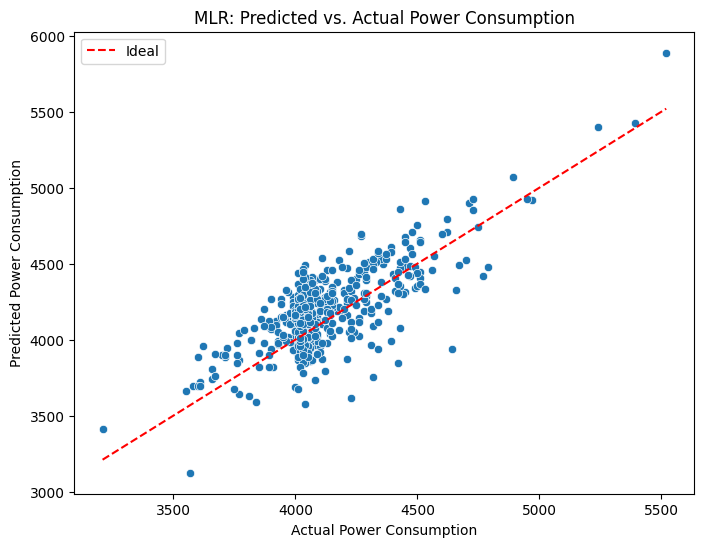


--- Model Evaluation ---
RMSE: 182.08662123644027
R² Score: 0.3390576000494684

Intercept: -21290.15256109404
Coefficients:
  연회회수: -5.653344778813208
  소요시간_추가1: 454.0523175727661
  통전시간_주요장입: 46.46596318229425
  비통전시간_추가1: -504.71125027298416
  유효전력량_주장: -0.6381745247740949
  유효전력량_추가1: -4.208211554115358
  무효전력량_주장: 0.1910310117898442
  무효전력량_추가1: 3.5515338717772074
  일차전력_주요장입: 0.05643256816239304
  일차전력_추가1: 0.2668379502483432
  일차력율_주요장입: 15.87194747917114
  일차력율_추가1: 318.1907691271119
  란스O2_추가1: 8.308794196183294
  란스O2_추가2: 11.163252680369332
  버너O2_주요장입: -9.257003617000004
  버너O2_추가1: -16.883421785738204
  버너오일_추가1: 3.314201908624764
  PSAO2_주요장입: 1.1333031536041995
  PSAO2_추가1: -8.574627589486658
  Tr권선온도_최저: -2.647394890350474
  Tr기름온도_최고: 9.67502582995698
  Tr기름온도_최저: 1.414942966596221
  A부스러기 손: 0.023475327705403615
  친단　손: 0.10334583191606228
  와셔 친: 0.0032232522088548876
  B부스러기　친: -0.011252305618086211
  B부스러기 자: -0.005516350351413735
  B부스러기 손: -0.02727199660337476
 

In [9]:
y_pred = model.predict(X_test)

# Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.title('MLR: Predicted vs. Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()
plt.show()

# Evaluation metrics
print("\n--- Model Evaluation ---")
MSE = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))
print("\nIntercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef}")

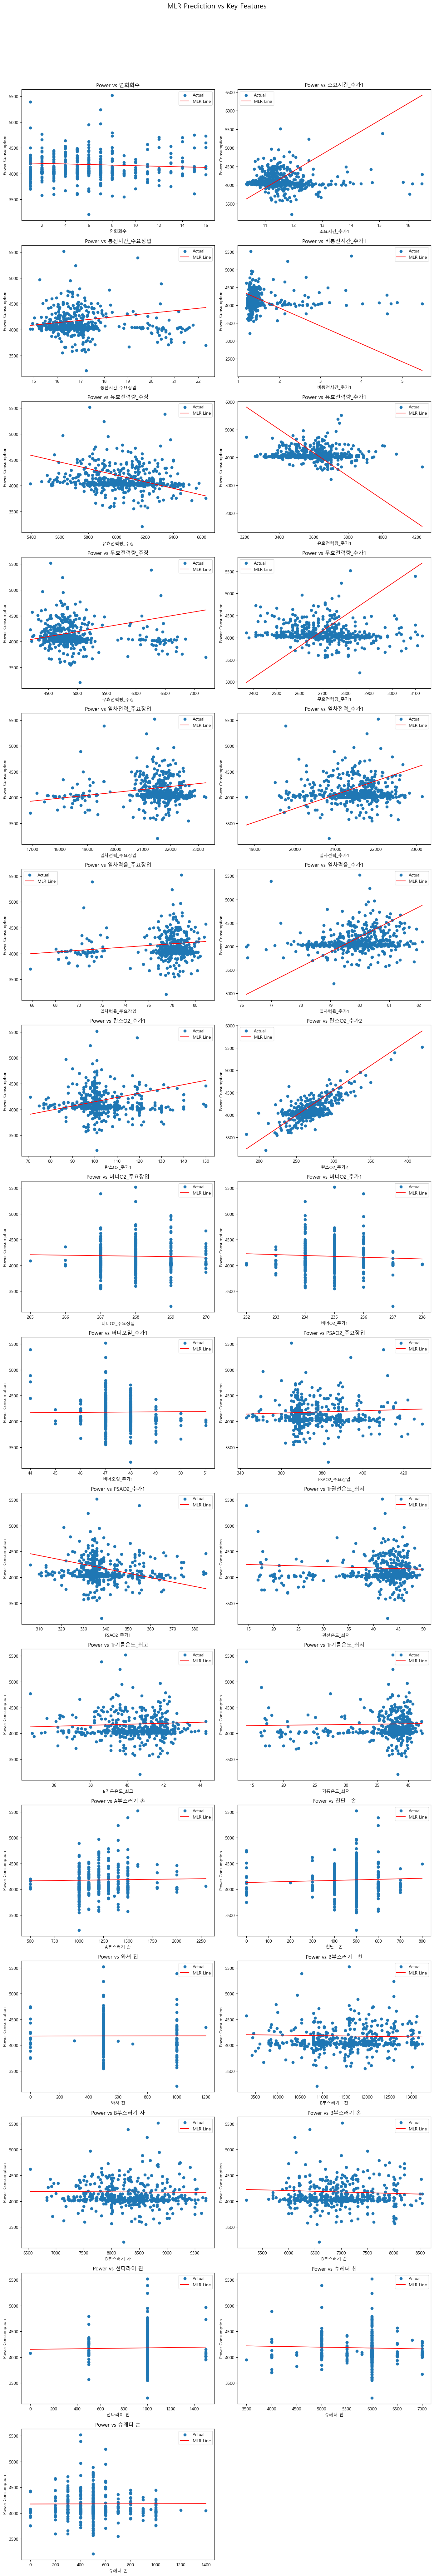

In [10]:
# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

feature_means = X_test.mean()

# Subplots
n_vars = len(variables)
cols = 2
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Generate subplots
for i, var in enumerate(variables):
    ax = axes[i]
    
    # x-axis values for current variable
    x_vals = np.linspace(X_test[var].min(), X_test[var].max(), 100)

    # Build manual prediction line using MLR
    y_vals = np.full_like(x_vals, model.intercept_, dtype=float)
    
    for j, col in enumerate(X_test.columns):
        if col == var:
            y_vals += model.coef_[j] * x_vals  # vary only current var
        else:
            y_vals += model.coef_[j] * feature_means[col]  # fix others at mean

    # Scatter actual vs predicted
    ax.scatter(X_test[var], y_test, alpha=1, label='Actual')
    ax.plot(x_vals, y_vals, color='red', label='MLR Line')
    ax.set_xlabel(var)
    ax.set_ylabel('Power Consumption')
    ax.set_title(f'Power vs {var}')
    ax.legend()

# Remove any unused axes (if total axes > variable count)
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('MLR Prediction vs Key Features', fontsize=16, y=1.03)
plt.show()

# MLR Time Series Data

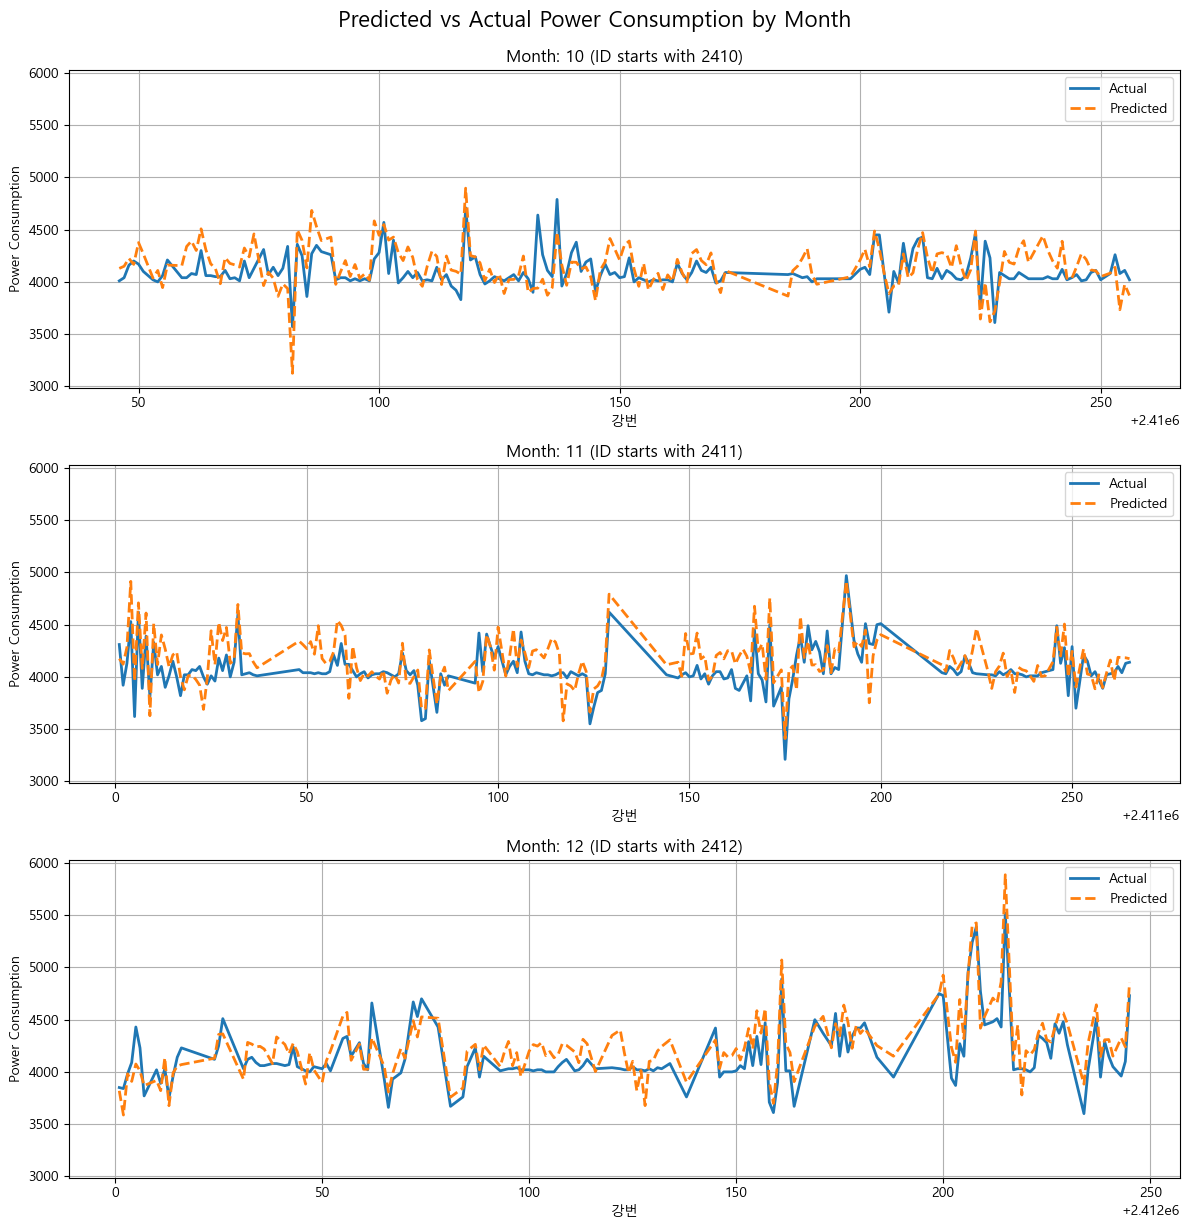

In [11]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual Power'] = y_test.values
id_aligned_df['Predicted Power'] = y_pred

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)
months = [10, 11, 12]

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual Power'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted Power'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel('Power Consumption')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Power Consumption by Month', fontsize=16, y=1.02)
plt.show()

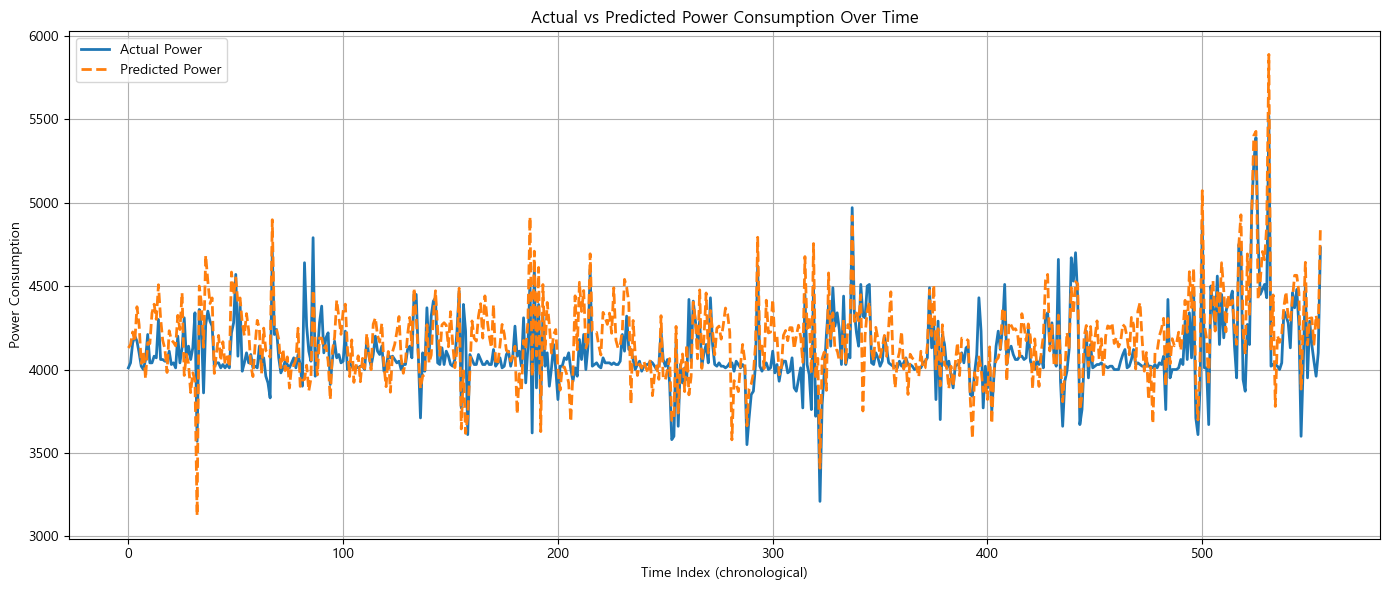

In [12]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual Power'], label='Actual Power', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted Power'], label='Predicted Power', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('Power Consumption')
plt.title('Actual vs Predicted Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost

In [13]:
# XGBoost Model set up
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth= 4,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

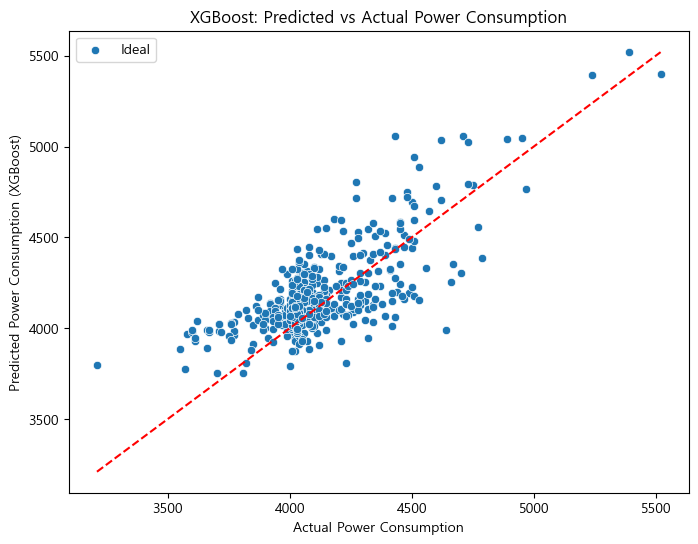


--- XGBoost Model Evaluation ---
Mean Squared Error: 27703.585541044424
XGBoost RMSE: 166.44394113648121
R² Score: 0.4477400874253682


In [14]:
# XGBoost Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=xgb_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption (XGBoost)')
plt.title('XGBoost: Predicted vs Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Ideal'])
plt.show()

# Evaluation
print("\n--- XGBoost Model Evaluation ---")
print("Mean Squared Error:", mean_squared_error(y_test, xgb_pred))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGBoost RMSE:", rmse_xgb)
print("R² Score:", r2_score(y_test, xgb_pred))

In [20]:
'''
# Features to plot
features = variables
n_features = len(features)
X_test = X_test.astype('float')

# Subplots
n_vars = len(variables)
cols = 2
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel('Predicted Power')
    ax.set_title(f'Predicted Power vs {feature}')
    ax.legend()

# Remove any unused subplot
if len(axes) > n_features:
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout()
plt.suptitle('Predicted Power vs Features with Partial Dependence (XGBoost)', fontsize=16, y=1.02)
plt.show()
'''

"\n# Features to plot\nfeatures = variables\nn_features = len(features)\nX_test = X_test.astype('float')\n\n# Subplots\nn_vars = len(variables)\ncols = 2\nrows = math.ceil(n_vars / cols)\n\nfig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))\naxes = axes.flatten()\n\n# Plot the features\nfor i, feature in enumerate(features):\n    ax = axes[i]\n    feature_index = X_test.columns.get_loc(feature)\n\n    # Partial dependence\n    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')\n    x_vals = pd_result['grid_values'][0]\n    y_vals = pd_result['average'][0]\n\n    # Scatter: actual model predictions\n    sns.scatterplot(\n        x=X_test[feature],\n        y=xgb_model.predict(X_test),\n        alpha=1,\n        ax=ax,\n        label='Predicted'\n    )\n\n    # Partial dependence line\n    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')\n\n    # Format\n    ax.set_xlabel(feature)\n    ax.set_ylabel('Predicted Power')

In [16]:
importances = xgb_model.feature_importances_
for var, imp in sorted(zip(X.columns, importances), key=lambda x: -x[1]):
    print(f"{var}: {imp}")

란스O2_추가2: 0.3859853148460388
유효전력량_주장: 0.07519520074129105
유효전력량_추가1: 0.0414104163646698
Tr기름온도_최고: 0.04070263355970383
PSAO2_추가1: 0.03298964351415634
버너O2_주요장입: 0.029177537187933922
B부스러기 손: 0.027123667299747467
일차력율_주요장입: 0.02442537620663643
무효전력량_추가1: 0.022559350356459618
PSAO2_주요장입: 0.020012378692626953
일차전력_추가1: 0.019932962954044342
비통전시간_추가1: 0.01927240937948227
슈레더 친: 0.0183678288012743
일차력율_추가1: 0.01791800931096077
Tr권선온도_최저: 0.01791510172188282
Tr기름온도_최저: 0.01783052273094654
일차전력_주요장입: 0.017089826986193657
무효전력량_주장: 0.01599644497036934
B부스러기　친: 0.015823127701878548
란스O2_추가1: 0.0158079881221056
버너오일_추가1: 0.015790415927767754
버너O2_추가1: 0.015210339799523354
연회회수: 0.015026114881038666
A부스러기 손: 0.014765656553208828
B부스러기 자: 0.013121437281370163
소요시간_추가1: 0.012881091795861721
통전시간_주요장입: 0.011028891429305077
와셔 친: 0.00911386962980032
슈레더 손: 0.00825533177703619
친단　손: 0.004651255439966917
선다라이 친: 0.004619752988219261


# Time Series Data

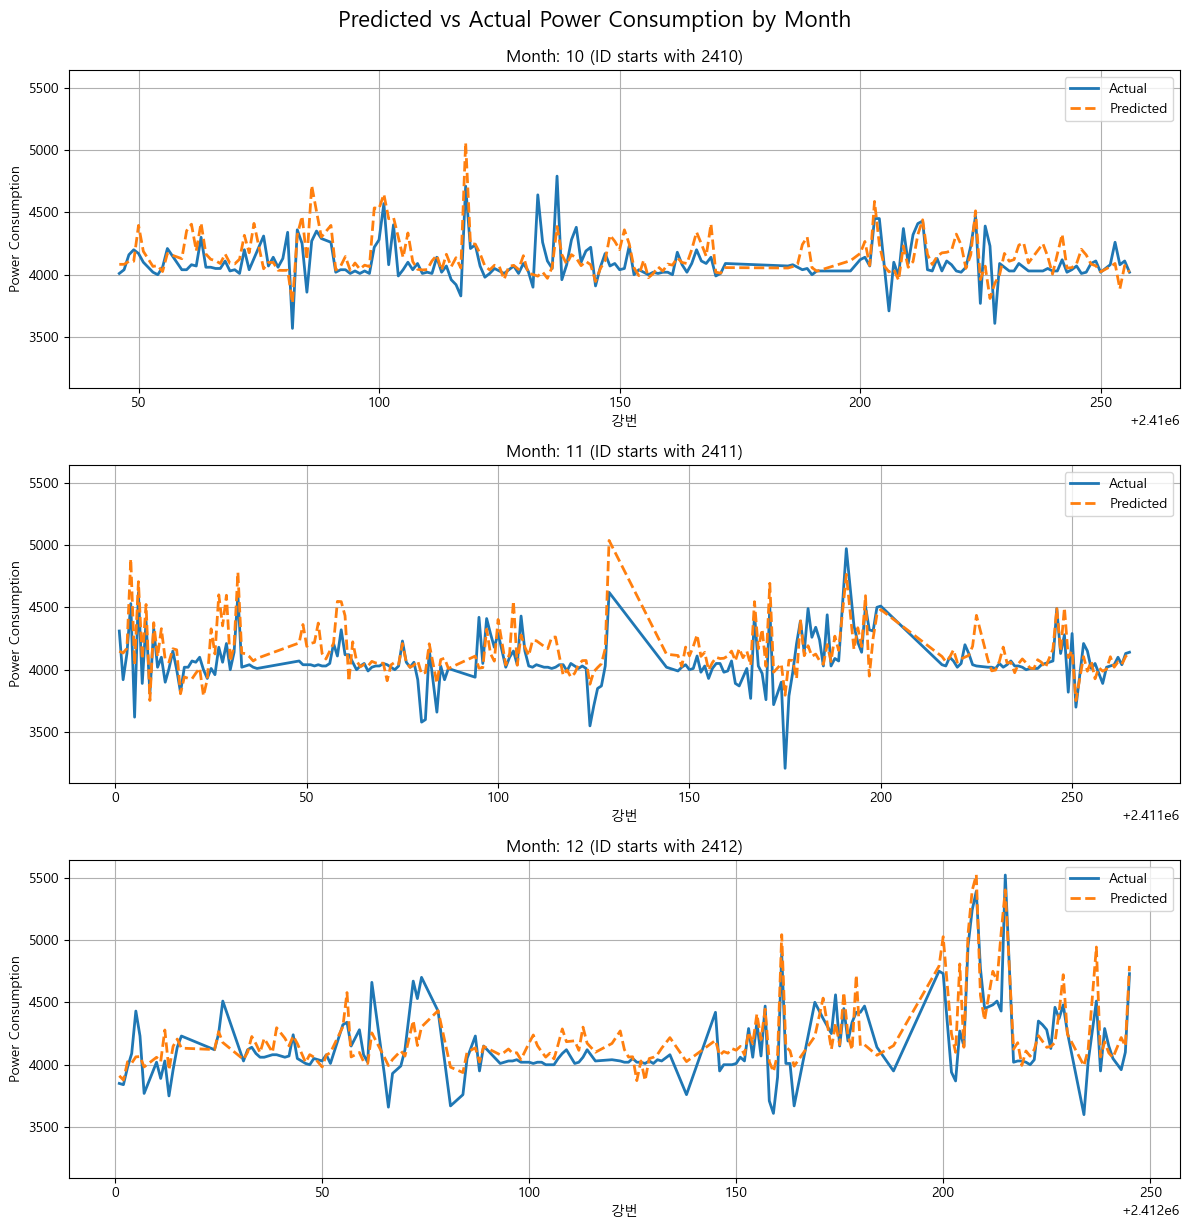

In [17]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual Power'] = y_test.values
id_aligned_df['Predicted Power'] = xgb_pred  # or xgb_pred for XGBoost

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)
months = [10, 11, 12]

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual Power'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted Power'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel('Power Consumption')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Power Consumption by Month', fontsize=16, y=1.02)
plt.show()

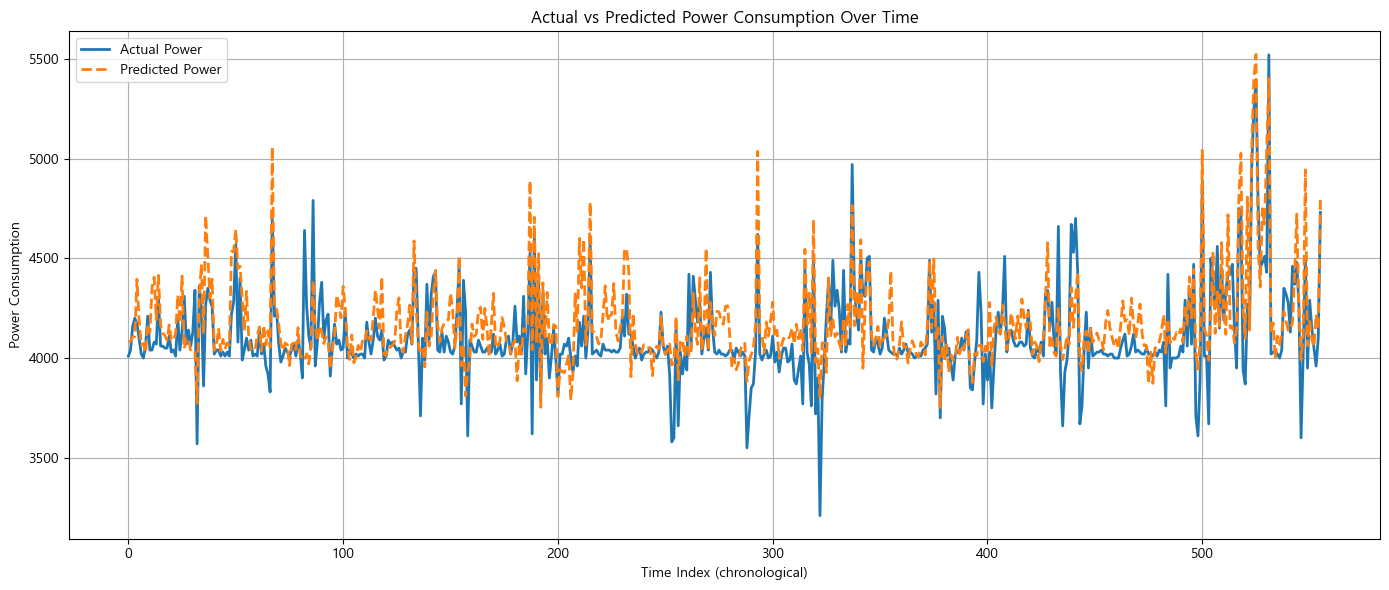

In [18]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual Power'], label='Actual Power', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted Power'], label='Predicted Power', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('Power Consumption')
plt.title('Actual vs Predicted Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

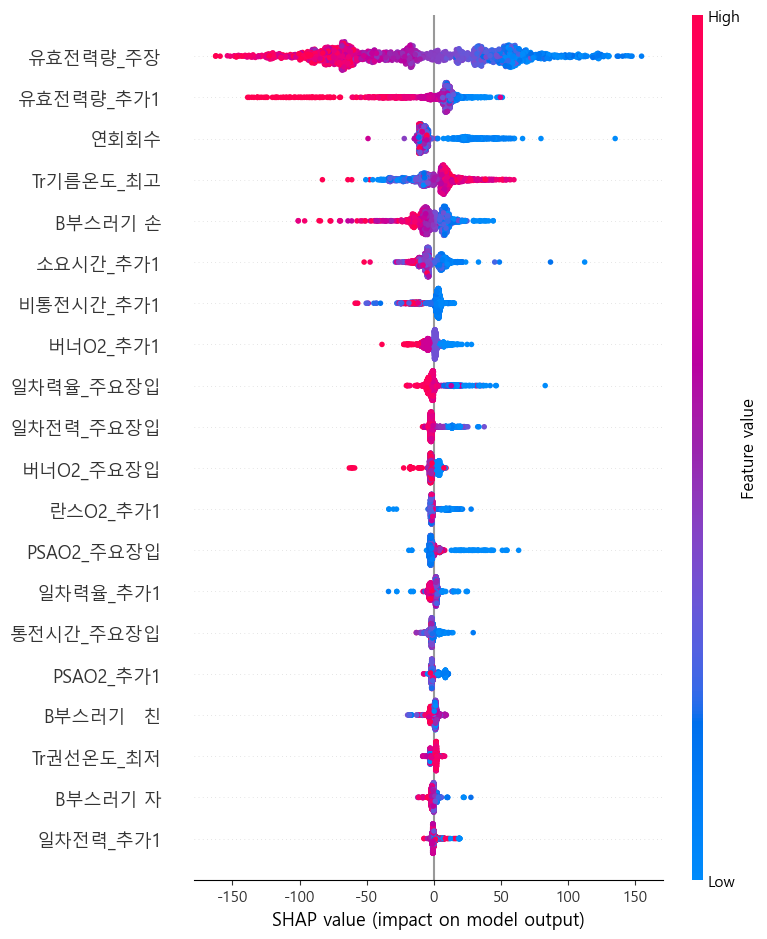

In [19]:
explainer = shap.TreeExplainer(xgb_model)

# Step 1: Compute SHAP values on full feature set
shap_values = explainer.shap_values(X)

# Step 2: Remove columns you don't want from both X and shap_values before plotting
exclude_vars = ['란스O2_추가2']

# Get column indices to keep
keep_columns = [col for col in X.columns if col not in exclude_vars]
keep_indices = [X.columns.get_loc(col) for col in keep_columns]

# Filter SHAP values and feature names
shap_values_filtered = shap_values[:, keep_indices]
X_filtered = X[keep_columns]

# Step 3: Plot
shap.summary_plot(shap_values_filtered, X_filtered)